# IBM Data Science Course
### Data Science Capstone (Week 2)

## Heinz's Shop

Lucas Friedrich Meincke<br>

## 1. Introduction

In this section, the purpose of this report is described. It is expected that the reader is already familiarized with basic python programming and data science concepts as the explanation about the fundamentals of those topics are not explained in this report.
<br><br>

### 1.1 Problem Description

When an entrepreneur wants to create a business such as a coffee shop or a restaurant, one of the most difficult things to do is to find the best place for it to be started considering its future concurrence and the characteristics of the city. For example: is it good for a business to be started downtown or at the city boundary? The climate conditions of the city could somehow influence my business? Is my concurrence doing a good job, or the customers are not being well-served? This report has the purpose to answer some questions based on these issues.
<br><br>

### 1.2 Problem Delimitation

My friend Heinz wants to become an entrepreneur and open an open-air shop in a city that is similar to his hometown Stuttgart, regarding his preferred places. Yes, he wants to move and live in a new place, but that brings him the "home feeling". Heinz is a "cult guy" who likes art, theater, and museums, but he also likes to enjoy nature and to go to parks and forests. During our conversation, he gave me all his preferences that now are listed in section 1.3 of this report. The city where Heinz will be moving to shall also has a good weather condition as he plans to serve his clients outside. Additionally, it shall be a good place for his business in terms of concurrence. By using data science techniques I will try to find the best place for my friend Heinz to start his business, based on the objectives described in section 1.3. As this report is part of the final essay of the IBM Data Science course, it does not have the intent to show the most recent data science methodologies neither the most efficient algorithms to solve the proposed problem but to expose using a practical approach, part of the theory learned during the course.
<br><br>

### 1.3 Objective

Find the best place for Heinz to open his coffee and ice cream shop in Germany using data scraped from the internet and Foursquare databases. The decision shall be based on what follows:

* It has to be a **big city**;
* The **precipitation rate** in the city should be low during the spring, summer, and autumn, then Heinz could attend his clients outside as many days as possible during the year;
* The **concurrence** should be weak based on the **score** from customers' reviews (venues' scores);
* The city has to be **similar to Stuttgart** based on Heinz's preferred venues, which are: Clubs, Concerts, Theaters, Museums, Pubs, Gardens, Forests, Hills, Lakes, Parks, Nature Places, and Rivers.
<br><br>

## 2. Data

In this section, the data collection, preparation, and analysis are shown.
<br><br>

### 2.1 Data Sources

* **Biggest cities in Germany:** these data were scraped from https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population
* **The precipitation rate of each city in Germany:** these data were scraped from the main Wikipedia page of each city, through a loop. For example, for the city of Berlin, the data were scraped from https://de.wikipedia.org/wiki/Berlin, for the city of Stuttgart from https://de.wikipedia.org/wiki/Stuttgart, and so on.
* **The venues in each city and their scores:** once having the latitude and longitude information for each city in Germany, it was possible to collect the information about their venues through the Foursquare API https://foursquare.com/. It was used two types of calls: regular calls for venue names, IDs, and categories, and premium calls for the score and ratings (customers' feedback).

Many adjusts had to be made in the data for them to be properly used for further analysis. All the data preparation process is shown in section 2.3.
<br><br>

### 2.2 Data Usage

The first step was to collect a list that contains the **biggest cities in Germany** and also their latitude and longitude information. By knowing the name of the biggest cities, it was possible, though a loop function, to scrap the weather information containing the **precipitation rate** of each city from Wikipedia. At this point, it is possible to filter only a few cities which have the lowest precipitation rate and thus narrow the options for Heinz to open his open-air coffee and ice cream shop. For this report, it was chosen 12 cities.
Once the best cities were filtered based on the climate condition, the **venues available** in each of these cities could be collected (through a regular call) and also their **scores** (through a premium call) using the Foursquare database.
At this point, the data containing the availability of the venues was spliced: one data frame containing Heinz's preferred venues in each city to compare them to Stuttgart, and a second data frame containing only the venues that would be Heinz's concurrence (coffees and ice cream shops) and also their scores. By using both data frames it was possible to select the city which would be the best option for him to open his shop based on both: the customers' feedback on the concurrence, and by using the k-clustering algorithm to find the most similar cities to Stuttgart.
<br><br>

### 2.3 Data Collection and Preparation
The data collection and preparation can be seen below alongside comments for each portion of the code.
<br><br>

### 2.3.1 Python Libraries
The following libraries were used for this analysis

In [1]:
import numpy as np
import pandas as pd
import requests #to request json files
import json #to lead with json files>
import folium #folium map
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.cluster.hierarchy as shc #to plot hierarchical graphics
from bs4 import BeautifulSoup #to scrap
from geopy.geocoders import Nominatim #to collect geo data
from sklearn.cluster import KMeans #k-clustering algorithms
from pandas.io.json import json_normalize #to normalize json files
from yellowbrick.cluster import KElbowVisualizer #yellowbrick visualizers to find k value

### 2.3.2 Biggest Cities in Germany
The data from the biggest cities in Germany were scraped from https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population and after some adjusts transformed into a dataframe called **df_cities**

In [183]:
#scraping the info from wikipedia
link1 = requests.get('https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population').text
soup1 = BeautifulSoup(link1, 'html.parser')

l = []

for td in soup1.find('tbody').find_all('td'):
    data = td.text.strip()
    data = data.replace(',', '')
    data = data.split(" / ", 1)
    data = data[-1]
    data = data.split(" / ", 1)
    data = data[0]
    data = data.replace('°N', ';')
    data = data.replace('°E', '')
    data = data.replace('\ufeff', '')
    data = data.replace('\xa0', '')
    l.append(data)

rows = int((len(l)/9)) # number of rows is the lengh of the list / number of columns (converted to int)
l = np.reshape(l, (rows, 9)) # reshaping the list into matrix

#adjusting the dataframe and renaming the columns
df_cities = pd.DataFrame(l, columns = ["Rank", "City", "State", "Population", "2011 Census", 
                                      "Change", "Land Area", "Pop. Dens.", "Location"])
df_cities[['Latitude','Longitude']] = df_cities.Location.str.split(";", expand=True,).astype('float').round(3)
df_cities[["City", "State"]] = df_cities[["City", "State"]].astype('string')
df_cities["Population"] = df_cities["Population"].astype('int')
df_cities = df_cities[["City", "State", "Population", "Latitude", "Longitude"]]
df_cities.replace({'Halle (Saale)': 'Saale', 'Munich (München)': 'München', 'Cologne (Köln)': 'Köln',
                  'Hanover (Hannover)': 'Hannover', 'Nuremberg (Nürnberg)': 'Nürnberg'}, inplace=True)
df_cities

,City,State,Population,Latitude,Longitude
0,Berlin,Berlin,3520031,52.517,13.383
1,Hamburg,Hamburg,1787408,53.550,10.000
2,München,Bavaria,1450381,48.133,11.567
3,Köln,North Rhine-Westphalia,1060582,50.933,6.950
4,Frankfurt am Main,Hesse,732688,50.117,8.683
...,...,...,...,...,...
75,Moers,North Rhine-Westphalia,104529,51.459,6.620
76,Siegen,North Rhine-Westphalia,102355,50.883,8.017
77,Hildesheim,Lower Saxony,101667,52.150,9.950
78,Salzgitter,Lower Saxony,101079,52.150,10.333


### 2.3.2 Weather Conditions in the Cities
Once having the name of the biggest cities in Germany it is possible, though a loop, to scrap from the wiki pages of each city their weather conditions. The output prints "error" when the wiki page for a specific city does not have the weather condition information and also the count of the occurred errors (in this case 19). The data that returned without error, after some adjust, was transformed into a data frame called **df_clima**

In [186]:
#scraping the infos from wikipedia
list_cities = list(df_cities["City"])
l = []
count = 0

for x in list_cities:
    try:
        link2 = requests.get(f'https://de.wikipedia.org/wiki/{x}').text
        soup2 = BeautifulSoup(link2, 'html.parser')
        tables = soup2.find('table', style='border: 5px solid #E5E5E5; font-size:95%; background:#E5E5E5; margin-bottom:10px;')  
        for row in tables.find_all('tr'):
            for td in row.find_all('td'):
                data = td.text.strip()
                data = data.replace('Jan', '').replace('Feb', '').replace('Mär', '').replace('Apr', '')
                data = data.replace('Mai', '').replace('Jun', '').replace('Jul', '').replace('Aug', '')
                data = data.replace('Sep', '').replace('Okt', '').replace('Nov', '').replace('Dez', '')
                data = data.replace(',', '.')
                data = data.replace('−', '-')
                l.append(data)
                l = list(filter(None, l))
            if data=="":
                continue
            else: l.append(x)
        print(x)
    except:
        count = count+1
        print('error')
        
print(count)
rows = int((len(l)/16)) # number of rows is the lengh of the list / number of columns (converted to int)
l = np.reshape(l, (rows, 16)) # reshaping the list into matrix

Berlin
Hamburg
München
Köln
Frankfurt am Main
Stuttgart
Düsseldorf
Dortmund
Essen
Leipzig
Bremen
Dresden
Hannover
Nürnberg
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Münster
Karlsruhe
Mannheim
Augsburg
Wiesbaden
Gelsenkirchen
Mönchengladbach
Braunschweig
Chemnitz
Kiel
Aachen
error
Magdeburg
Freiburg im Breisgau
Krefeld
Lübeck
Oberhausen
Erfurt
Mainz
Rostock
Kassel
error
Hamm
Saarbrücken
error
Potsdam
error
error
Leverkusen
Osnabrück
Solingen
Heidelberg
Herne
Neuss
Darmstadt
error
Regensburg
error
Würzburg
error
error
Offenbach am Main
Ulm
Heilbronn
Pforzheim
error
error
Trier
error
error
Bremerhaven
Koblenz
Bergisch Gladbach
error
error
error
error
Siegen
error
error
Kaiserslautern
19


In [187]:
#adjusting the dataframe and renaming the columns
df_clima = pd.DataFrame(l, columns=["Measure", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul",
                        "Aug", "Sep", "Oct", "Nov", "Dec", "Sum/Avg", "Total", "City"])
df_clima = df_clima.astype({'Measure': 'string', 'Jan': 'float64', 'Feb': 'float64', 'Mar': 'float64',
                           'Apr': 'float64', 'May': 'float64', 'Jun': 'float64', 'Jul': 'float64',
                           'Aug': 'float64', 'Sep': 'float64', 'Oct': 'float64', 'Nov': 'float64',
                           'Dec': 'float64', 'Sum/Avg': 'string', 'Total': 'float64', 'City': 'string'})
mask = df_clima['Measure'].isin(['Regentage (d)', 'Sonnenstunden (h/d)', 'Luftfeuchtigkeit (%)',
                          'Temperatur (°C)', 'Rekordmaximum (°C)', 'Rekordminimum (°C)'])
df_clima = df_clima[~mask].reset_index(drop=True)
df_clima["Measure"] = df_clima['Measure'].replace(["Max. Temperatur (°C)", "Min. Temperatur (°C)", "Niederschlag (mm)"],
                                      ["Max. Temp. (°C)", "Min. Temp. (°C)", "Precipitation (mm)"])
df_clima

,Measure,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Sum/Avg,Total,City
0,Max. Temp. (°C),2.9,4.2,8.5,13.2,18.9,21.6,23.7,23.6,18.8,13.4,7.1,4.4,Ø,13.4,Berlin
1,Min. Temp. (°C),-1.9,-1.5,1.3,4.2,9.0,12.3,14.3,14.1,10.6,6.4,2.2,-0.4,Ø,5.9,Berlin
2,Precipitation (mm),42.3,33.3,40.5,37.1,53.8,68.7,55.5,58.2,45.1,37.3,43.6,55.3,Σ,570.7,Berlin
3,Max. Temp. (°C),3.5,4.4,8.0,12.3,17.5,19.9,22.1,22.2,17.9,13.0,7.5,4.6,Ø,12.8,Hamburg
4,Min. Temp. (°C),-1.4,-1.2,1.1,3.3,7.4,10.5,12.7,12.5,9.6,6.0,2.4,0.0,Ø,5.3,Hamburg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Min. Temp. (°C),-1.5,-1.6,0.3,3.8,7.4,10.6,13.0,12.1,8.9,5.4,3.0,0.0,Ø,5.2,Siegen
174,Precipitation (mm),107.0,66.0,63.0,41.0,67.0,75.0,84.0,83.0,58.0,78.0,96.0,112.0,Σ,930.0,Siegen
175,Max. Temp. (°C),4.0,5.0,10.0,13.0,19.0,22.0,25.0,25.0,20.0,15.0,9.0,5.0,Ø,14.4,Kaiserslautern
176,Min. Temp. (°C),-1.0,-2.0,2.0,3.0,8.0,12.0,14.0,13.0,9.0,6.0,3.0,1.0,Ø,5.7,Kaiserslautern


In [188]:
#verifying how many cities have the precipitation data collected.
df_clima.groupby('Measure')['City'].nunique()

Measure
Max. Temp. (°C)       59
Min. Temp. (°C)       59
Precipitation (mm)    60
Name: City, dtype: int64

### 2.3.3 The Main Dataframe
As only the precipitation rate and average temperatures during the spring, summer, and autumn (the seasons when the clients will be attended outside the shop) are needed, the data frame containing the weather conditions was summarized by city and merged to **df_cities**. The data frame **df_main** was then created containing the top 12 cities with less precipitation rate plus Stuttgart, Heinz' hometown.

In [189]:
#creating the main dataframe from df_clima and df_cties
df_main = df_clima[['City', 'Measure']]
df_main['Total'] = (df_clima['Mar'] + df_clima['Apr'] + df_clima['May'] + df_clima['Jun'] + 
                         df_clima['Jul'] + df_clima['Aug'] + df_clima['Sep'] + df_clima['Oct'])
df_main = df_main.pivot(index='City', columns='Measure')['Total'].reset_index().round(3)
df_main["Summed Avg. Temp. (°C)"] = ((df_main["Max. Temp. (°C)"] + df_main["Min. Temp. (°C)"])/2/8).round(2)
df_main = pd.merge(df_main, df_cities, on ='City', how ='inner')
df_main = df_main[["City", "Precipitation (mm)", "Summed Avg. Temp. (°C)", "Population", "Latitude", "Longitude"]].round(2).sort_values(
                                by=["Precipitation (mm)", "Summed Avg. Temp. (°C)"], ascending=[True, False])
df_main = df_main.dropna()
stuttgart_row = df_main.query('City=="Stuttgart"')
df_main = df_main.head(12) 
df_main = pd.concat([df_main, stuttgart_row]).reset_index(drop=True)
df_main

<ipython-input-189-2bcc37f5d4df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['Total'] = (df_clima['Mar'] + df_clima['Apr'] + df_clima['May'] + df_clima['Jun'] +


,City,Precipitation (mm),Summed Avg. Temp. (°C),Population,Latitude,Longitude
0,Magdeburg,347.6,12.96,235723,52.13,11.62
1,Leipzig,357.0,13.93,560472,51.33,12.38
2,Nürnberg,371.0,14.13,509975,49.45,11.08
3,Mainz,377.0,13.61,209779,50.00,8.27
4,Pforzheim,377.6,13.91,122247,48.90,8.72
5,Erfurt,384.0,12.03,210118,50.98,11.03
6,Dresden,387.0,14.74,543825,51.03,13.73
7,Berlin,396.2,13.37,3520031,52.52,13.38
8,Heidelberg,401.0,15.21,156267,49.42,8.72
9,Mannheim,401.0,15.21,305780,49.48,8.47


### 2.3.4 Exploring the Cities with Foursquare
The latitude and longitude information from **df_main** data frame was used to explore the venues of each city by using a regular call to the Fourquare database. the venues were filtered in two different ways: first with the venues that would be concurrence to Heinz (Café, Koffee Shops, Ice Cream Shops, and Bistros), generating the data frame **df_venues_conc**. To keep the data as clean as possible those four categories of concurrent venues were recategorized into only two (Café and Ice Cream Shop). The venues' ID information was also collected to be used through a premium call to the Fourquare database, and return the customers' feedback (venue score). The rating information which is the number of feedbacks was also collected just to verify if a sufficient amount of feedbacks were posted to compose each score. The second data frame **df_venues_pref** was created with Heinz's preferred venues only, which will be used to compare Stuttgart to the other cities.

In [190]:
#credencials to be used with Foursquare API
CLIENT_ID = 'ZHZIJHIFEQCF4TUT3UOFXEVMSMTSOQ204ALBKXBCNMH2WXRA'
CLIENT_SECRET = '41I33OL4YE34QS5VWJXTNMSWCQFV143GKLFQ4OA1CQL0B2V4'
VERSION = '20180605'
LIMIT = 100 #default Foursquare API limit value

In [214]:
#function to collect all the venues for each city
def getNearbyVenues(names, latitudes, longitudes, radius=8000): #radius of 8km returned the max. number of venues
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        #API request URL (regular call)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        venues_list.append([(
            name,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City Name',
                             'Venue ID',
                             'Venue Name', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

#funciton parameters
df_venues_all = getNearbyVenues(names=df_main['City'],
                            latitudes=df_main['Latitude'],
                            longitudes=df_main['Longitude'])

In [219]:
#creating the dataframe containing only the concurrent shops
df_venues_conc = df_venues_all[df_venues_all['Venue Category'].str.contains('Ice|Café|Coffee Shop|Bistro')].reset_index(drop=True)
df_venues_conc.replace({'Coffee Shop': 'Café', 'Bistro': 'Café'}, inplace=True)

#creating the dataframe containing the Heinz' prefered venues
df_venues_pref = df_venues_all[df_venues_all['Venue Category'].str.contains('Club|Concert|Theater|Museum|Pub|Garden|Forest|Hill|Lake|Park|Nature|River')].reset_index(drop=True)

df_venues_pref

,City Name,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Magdeburg,4bd464ebcfa7b713b4ee23da,Kulturhistorisches Museum,52.125470,11.629250,History Museum
1,Magdeburg,4d15ec556c8b5481406ee1cc,Stadtpark Rotehorn,52.116431,11.641090,Park
2,Magdeburg,505b6d8be4b03e4e73c3a84d,Opernhaus Magdeburg,52.137391,11.638469,Concert Hall
3,Magdeburg,53938089498e97c3af3dcb88,Schweizer Milchkuranstalt,52.122950,11.634850,Beer Garden
4,Magdeburg,4b98e02bf964a520a55335e3,Theater Magdeburg,52.137365,11.639108,Theater
...,...,...,...,...,...,...
174,Stuttgart,4b1d7ff5f964a520591124e3,Mercedes-Benz Museum,48.788169,9.234138,Museum
175,Stuttgart,4c8399d9dc018cfae1bed96c,Santiago-de-Chile-Platz,48.755496,9.172667,Park
176,Stuttgart,4bd08530b221c9b630d6d3d0,Biergarten Schlossgarten,48.784496,9.186104,Beer Garden
177,Stuttgart,532eb904498e2b589ca0a7a8,Gewächshäuser | Wilhelma,48.804081,9.207995,Botanical Garden


### 2.3.5 Collecting the Venues Scores with Foursquare
Using the venue's ID information, the customers' feedback (venue score) could be acquired and saved into the data frame **df_scores**. The rating data which is the number of feedbacks were also collected just to verify if a sufficient amount of feedbacks were posted to compose each score. Finally, the **df_scores** could be merged into **df_venues_conc**.

In [221]:
#function to collect the scores for each venue that is a concorrent shop
def getVenuesScore(ID):
    
    score_list=[]
    for ids in ID:
        
        #API request URL (regular call)
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            ids,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            LIMIT)
            
        results = requests.get(url).json()["response"]["venue"]
        score_list.append([results.get(v) for v in ["id", "rating", "ratingSignals"]])   

    scores = pd.DataFrame(score_list, columns = ["Venue ID", "Score", "Rating"])
    return(scores)

#function parameters
df_scores = getVenuesScore(ID=df_venues_conc['Venue ID'])
df_scores

<bound method NDFrame.head of                      Venue ID  Score  Rating
0    561a856e498ee6fc8b49cafb    8.3     9.0
1    4dc53e2345dd2645526a7f15    8.4    17.0
2    4cb5ddce1b0af04d8a64cc25    7.5    14.0
3    51e3cd828bbde0ebc2f0d32f    8.5    80.0
4    548137ca498eb80c2a45fc33    8.7    45.0
..                        ...    ...     ...
149  53e89bfe498e2fc08ba33412    8.5     9.0
150  4ea478f47beb98c09bcc1547    7.9   280.0
151  563e1dd8cd1028d37ef044b1    8.5    13.0
152  57bb5dfb498e86d2c115234b    8.1    50.0
153  5ad8762a8c812a57d7ca4663    8.2    34.0

[154 rows x 3 columns]>

In [222]:
#merging df_scores into df_venues_conc
df_venues_conc = pd.merge(df_venues_conc, df_scores, on ='Venue ID', how ='outer')
df_venues_conc

,City Name,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Score,Rating
0,Magdeburg,561a856e498ee6fc8b49cafb,Herzstück - Das Kuchenatelier,52.133728,11.615929,Café,8.3,9.0
1,Magdeburg,4dc53e2345dd2645526a7f15,Eis-Konditorei Bortscheller,52.106756,11.640792,Ice Cream Shop,8.4,17.0
2,Magdeburg,4cb5ddce1b0af04d8a64cc25,Il Capitello,52.126257,11.634307,Café,7.5,14.0
3,Leipzig,51e3cd828bbde0ebc2f0d32f,Handbrotzeit,51.341338,12.378071,Café,8.5,80.0
4,Leipzig,548137ca498eb80c2a45fc33,Espresso Zack Zack,51.332784,12.404315,Café,8.7,45.0
...,...,...,...,...,...,...,...,...
149,Stuttgart,53e89bfe498e2fc08ba33412,Kantinchen,48.763924,9.176687,Café,8.5,9.0
150,Stuttgart,4ea478f47beb98c09bcc1547,Starbucks,48.776407,9.175892,Café,7.9,280.0
151,Stuttgart,563e1dd8cd1028d37ef044b1,Schwarzmahler,48.785164,9.209637,Café,8.5,13.0
152,Stuttgart,57bb5dfb498e86d2c115234b,misch misch,48.765881,9.169148,Café,8.1,50.0


### 2.3.6 Dataframes Summary
With the data collected so far is possible to help Heinz. A summary of the data frames that will be used from now on is shown below:

**df_main**: data frame containing the top 12 big cities with the lowest precipitation rate (not counting the winter) plus Stuttgart, their latitudes and longitudes, but also their summed average temperature and population (these last 2 only for consult).<br>
**df_venues_pref**: data frame containing Heinz's preferred venues of the 12 cities plus Stuttgart so that they can be clustered.<br>
**df_venues_conc**: data frame containing the venues of the 12 cities that would be the concurrence for Heinz (Cafés and Ice Cream Shops) and their scores.

In [224]:
#saving the dataframes into CSVs files
df_main.to_csv(r'L:\PythonProjects\coursera_capstone\week2\datasets\df_main.csv', index = False)
df_venues_pref.to_csv(r'L:\PythonProjects\coursera_capstone\week2\datasets\df_venues_pref.csv', index = False)
df_venues_conc.to_csv(r'L:\PythonProjects\coursera_capstone\week2\datasets\df_venues_conc.csv', index = False)

## 3. Methodology

In this section, data science techniques and tools such as one-hot encoding, k-mean clustering, and folium map for data visualization are used on the data collected to give Heinz the best help possible on his decision. The idea is to start clustering the cities regarding their venues to find those which are most similar to Stuttgart. After narrowing the list of cities only with those in the same cluster as Stuttgart, it was possible to select the one which has the concurrence with the lowest average score. The procedure and data manipulation are shown in the following topics.
<br><br>

### 3.1 One Hot Encoding

One hot encoding is a method used to convert categorical values into numbers so that is possible to use machine learning algorithms on them. The method was used in the **df_venues_pref** data frame.

In [226]:
#reading the csv files
df_main = pd.read_csv('L:\PythonProjects\coursera_capstone\week2\datasets\df_main.csv')
df_venues_pref = pd.read_csv('L:\PythonProjects\coursera_capstone\week2\datasets\df_venues_pref.csv')
df_venues_conc = pd.read_csv('L:\PythonProjects\coursera_capstone\week2\datasets\df_venues_conc.csv')

In [292]:
#one hot encoding
venues_onehot = pd.get_dummies(df_venues_pref[['Venue Category']], prefix="", prefix_sep="")
venues_onehot['City Name'] = df_venues_pref['City Name'] #add City Name column back to venues_onehot dataframe

#moving City Name column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

#creating the grouped and normalized dataframe to be used in the kmean function
venues_grouped = venues_onehot.groupby('City Name').mean().reset_index()
venues_grouped

,City Name,Art Museum,Beer Garden,Botanical Garden,Comedy Club,Concert Hall,Forest,Garden,Garden Center,History Museum,...,Lake,Movie Theater,Museum,Nature Preserve,Park,Pub,Public Art,Science Museum,Sculpture Garden,Theater
0,Berlin,0.100000,0.000000,0.0000,0.000000,0.200000,0.000000,0.150000,0.000000,0.050000,...,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.050000,0.000000,0.000000
1,Bremen,0.062500,0.062500,0.0000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,...,0.125000,0.000000,0.000000,0.000000,0.187500,0.187500,0.000000,0.062500,0.000000,0.062500
2,Dresden,0.058824,0.058824,0.0000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,...,0.000000,0.058824,0.117647,0.000000,0.235294,0.000000,0.000000,0.176471,0.000000,0.058824
3,Erfurt,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.714286,0.000000,0.142857,0.000000,0.000000,0.000000
4,Heidelberg,0.142857,0.000000,0.0000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.142857,0.000000,0.142857
5,Leipzig,0.045455,0.045455,0.0000,0.000000,0.090909,0.000000,0.000000,0.000000,0.045455,...,0.000000,0.000000,0.090909,0.045455,0.272727,0.045455,0.000000,0.000000,0.000000,0.090909
6,Magdeburg,0.066667,0.066667,0.0000,0.000000,0.066667,0.000000,0.000000,0.000000,0.133333,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.133333,0.000000,0.000000,0.000000,0.133333
7,Mainz,0.000000,0.000000,0.0000,0.000000,0.090909,0.090909,0.000000,0.090909,0.090909,...,0.000000,0.090909,0.000000,0.000000,0.363636,0.000000,0.000000,0.000000,0.090909,0.090909
8,Mannheim,0.111111,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.111111,0.000000,0.111111
9,Nürnberg,0.000000,0.105263,0.0000,0.052632,0.052632,0.000000,0.000000,0.000000,0.157895,...,0.052632,0.000000,0.000000,0.000000,0.473684,0.000000,0.000000,0.000000,0.000000,0.052632


### 3.2 Finding the Best Value for K 
K-means is the most popular algorithm used in unsupervised Machine Learning problems. The main question when using the k-mean algorithm is about the value of the k, which is the number of clusters that a data frame is grouped into. Therefore, it is necessary to find the best k value before using the k-mean clustering model. There are different algorithms to do so, but in this report, four of the most known methods were tried: the elbow curve, the silhouette method, the Calinski-Harabasz criteria, and the dendrogram diagram. All of them were implemented with the help of the Yellowbrick library. It is possible to see below that the "elbow" pattern was formed right on the value 4. With the silhouette method, the k value given was 2, but the value 4 has also a high score. The same occurs when using the Calinski-Harabasz criteria. The dendrogram diagram highlights 3 distinct clusters.
It was assumed 4 for the k value as it was the value returned by the elbow curve method and the second value with the highest returned score by the silhouette method and by the Calinski-Harabasz criteria. It is also not far from the number of clusters returned by the dendrogram diagram.

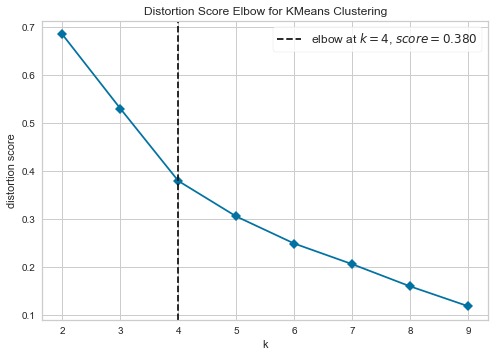

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [329]:
#droping the City Name column again to be used in Kmean function
venues_grouped_clustering = venues_grouped.drop('City Name', 1)

#elbow curve method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(venues_grouped_clustering)                         
visualizer.show()

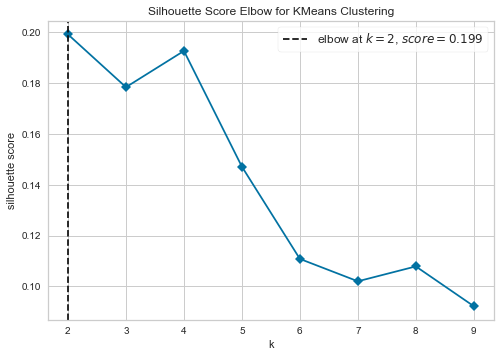

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [374]:
#silhouette method
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette', timings=False)
visualizer.fit(venues_grouped_clustering)
visualizer.show()

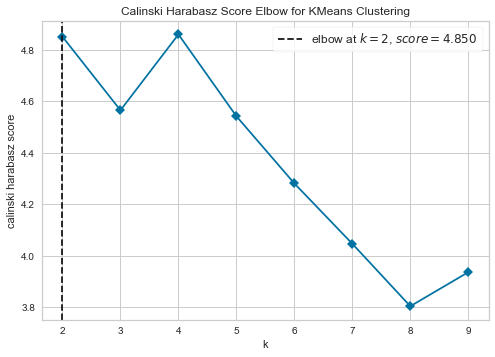

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [379]:
#Calinski-Harabasz criteria
visualizer = KElbowVisualizer(model, k=(2,10),metric='calinski_harabasz', timings=False)
visualizer.fit(venues_grouped_clustering)        
visualizer.show()

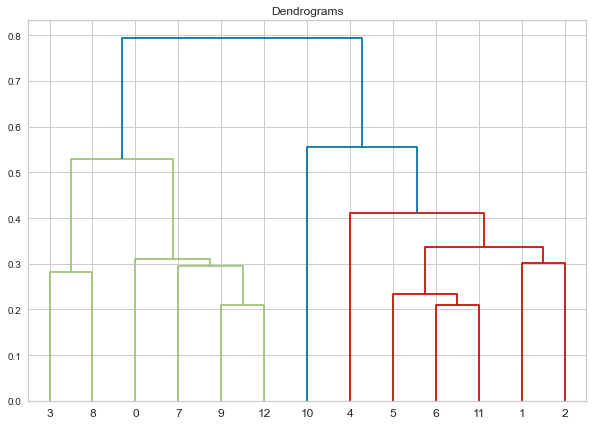

In [377]:
#dendogram diagram
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(venues_grouped_clustering, method='ward'))

### 3.3 Clustering the Cities
Once having 4 as the k value, the cities were clustered using the k-means algorithm, and a map was plotted using the Folium library. It is possible to see below that six cities are similar to Stuttgart regarding Heinz's preferred venues and are listed in cluster 2. They are: **Magdeburg, Nürnberg, Mainz, Berlin, and Potsdam**.

In [382]:
k = 4
#different n_init values were tested but the result did not change, then 30 was used.
kmeans = KMeans(n_clusters = k, n_init=30, random_state=0).fit(venues_grouped_clustering)
kmeans.labels_[0:13]

array([2, 1, 1, 0, 1, 1, 2, 2, 0, 2, 3, 2, 2])

In [383]:
#creating a dataframe with cluster number, latitude, longitude and city names to be used on the map
venues_map = pd.DataFrame()
venues_map['City Name'] = venues_grouped['City Name']
venues_map['Cluster'] = kmeans.labels_
venues_map = df_main.join(venues_map.set_index('City Name'), on='City').drop(['Population', 
                                                                              'Summed Avg. Temp. (°C)',
                                                                              'Precipitation (mm)'], axis=1)
venues_map

,City,Latitude,Longitude,Cluster
0,Magdeburg,52.13,11.62,2
1,Leipzig,51.33,12.38,1
2,Nürnberg,49.45,11.08,2
3,Mainz,50.00,8.27,2
4,Pforzheim,48.90,8.72,3
5,Erfurt,50.98,11.03,0
6,Dresden,51.03,13.73,1
7,Berlin,52.52,13.38,2
8,Heidelberg,49.42,8.72,1
9,Mannheim,49.48,8.47,0


In [384]:
#geolocator funciton to get Germany location
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Germany')
latitude = location.latitude
longitude = location.longitude

#creating the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

#set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_map['Latitude'], venues_map['Longitude'], venues_map['City'], venues_map['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.4 Concurrence and their Scores
The venues in each city listed in the data frame **df_venues_conc** were grouped and with that the mean of the scores given by the customers to the local coffee and ice cream shops could be verified. The cluster information was merged, resulting in a final data frame that was narrowed filtering only the cities labeled with cluster 2. The resulting data frame **df_results** is shown below. Now we know the cities that are most similar to Stuttgart regarding Heinz's preferences and also the mean of the scores given to Heinz's concurrence in each city. 

In [385]:
df_venues_conc_grouped = df_venues_conc[['City Name', 
                                         'Score', 
                                         'Rating']].groupby(['City Name'], 
                                         as_index=False).mean().sort_values(by=["Score"], 
                                         ascending=[True]).reset_index(drop=True).round(2)
df_venues_conc_grouped

,City Name,Score,Rating
0,Pforzheim,7.47,15.57
1,Dresden,7.86,80.60
2,Potsdam,7.91,45.77
3,Mannheim,8.06,64.06
4,Magdeburg,8.07,13.33
5,Erfurt,8.07,23.43
6,Mainz,8.18,42.06
7,Leipzig,8.28,43.42
8,Bremen,8.30,33.33
9,Heidelberg,8.41,83.00


In [388]:
df_results = pd.DataFrame()
df_results = df_venues_conc_grouped.drop(['Rating'], axis=1)
df_results = venues_map.join(df_results.set_index('City Name'), on='City').drop(['Latitude', 'Longitude'], axis=1)
df_results.sort_values(by=["Cluster", "Score"], ascending=[True,True], inplace=True)
df_results.reset_index(drop=True)

,City,Cluster,Score
0,Mannheim,0,8.06
1,Erfurt,0,8.07
2,Dresden,1,7.86
3,Leipzig,1,8.28
4,Bremen,1,8.30
5,Heidelberg,1,8.41
6,Potsdam,2,7.91
7,Magdeburg,2,8.07
8,Mainz,2,8.18
9,Stuttgart,2,8.46


## 4 Results
By the analysis done so far, the city of Potsdam could be declared as a good city for Heinz to start his business as it belongs to the same cluster as Stuttgart, and has a concurrence with a low score according to the customers' feedback. A map with the concurrent venues in Potsdam is shown below, where the black points refer to coffee shops and the blue points refer to ice cream shops. The map helps as a good start point to analyze in which part of the city would be the best place to open the shop, taking into account, for example, the place with less concurrence in terms of quantity, or the place which has the lowest rent price.

In [389]:
#dividing the concurrent venues in Dresden into two categories: cafés and ice cream shops 
df_venues_conc_potsdam = df_venues_conc[df_venues_conc['City Name']=='Potsdam']
df_venues_conc_potsdam_cafe = df_venues_conc_potsdam[df_venues_conc_potsdam['Venue Category']=='Café']
df_venues_conc_potsdam_ice = df_venues_conc_potsdam[df_venues_conc_potsdam['Venue Category']=='Ice Cream Shop']

#colect geo data of Dresden
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Potsdam')
latitude = location.latitude
longitude = location.longitude
   
#create map
map_potsdam = folium.Map(location=[latitude, longitude], zoom_start=14)
category = folium.map.FeatureGroup()
        
for lat, lon, score in zip(df_venues_conc_potsdam_cafe['Venue Latitude'], 
                           df_venues_conc_potsdam_cafe['Venue Longitude'],
                           df_venues_conc_potsdam_cafe['Score']):
    label1=folium.Popup('Score ' + str(score), parse_html=True)
    category.add_child(
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            color='black',
            fill=True,
            fill_color='black',
            fill_opacity=0.7,
            popup=label1)
    )   
    
for lat, lon, score in zip(df_venues_conc_potsdam_ice['Venue Latitude'], 
                           df_venues_conc_potsdam_ice['Venue Longitude'],
                           df_venues_conc_potsdam_ice['Score']):
    label2=folium.Popup('Score ' + str(score), parse_html=True)
    category.add_child(
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=label2)
    )      
    
# add incidents to map
map_potsdam.add_child(category)
map_potsdam

Other cities that belong to the same cluster as Stuttgart, that is, have a similar distribution of venues that Heinz likes to frequent. Furthermore, other cities have good weather conditions, similar to Potsdam. Even Potsdam being the best city for Heinz to open his business taking into account the objectives stipulated in section 1.3, the final decision will be taken by him. To help him a little bit more, a final data frame was created, summarizing all the important information collected so far. The last five columns were added, containing the five most recurrent venues in each city of cluster 2.

In [425]:
#define function that identifies the most common venues in city
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#identify the most common venues in the city using the function above
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#create a new dataframe
venues_top = pd.DataFrame(columns=columns)
venues_top['City'] = venues_grouped['City Name']

for ind in np.arange(venues_grouped.shape[0]):
    venues_top.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berlin,Park,Concert Hall,Garden,Art Museum,Science Museum
1,Bremen,Pub,Park,Indie Movie Theater,Lake,Art Museum
2,Dresden,Park,Science Museum,Indie Movie Theater,Museum,Art Museum
3,Erfurt,Park,Public Art,Garden Center,Art Museum,Jazz Club
4,Heidelberg,Art Museum,Garden,Science Museum,Pub,Park
5,Leipzig,Park,Indie Movie Theater,Irish Pub,Museum,Theater
6,Magdeburg,Park,Theater,History Museum,Pub,Beer Garden
7,Mainz,Park,Theater,Movie Theater,Sculpture Garden,Concert Hall
8,Mannheim,Park,Art Museum,Science Museum,Theater,Concert Hall
9,Nürnberg,Park,History Museum,Beer Garden,Irish Pub,Lake


In [426]:
df_results_2 = df_results[df_results['Cluster']==2].reset_index(drop=True)
df_results_2 = pd.merge(df_results_2, df_main, on ='City', how ='inner').drop(['Latitude', 'Longitude'], 1)
df_results_2 = pd.merge(df_results_2, venues_top, on ='City', how ='inner')
df_results_2

,City,Cluster,Score,Precipitation (mm),Summed Avg. Temp. (°C),Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Potsdam,2,7.91,401.0,12.96,167745,Park,Botanical Garden,Pub,Art Museum,History Museum
1,Magdeburg,2,8.07,347.6,12.96,235723,Park,Theater,History Museum,Pub,Beer Garden
2,Mainz,2,8.18,377.0,13.61,209779,Park,Theater,Movie Theater,Sculpture Garden,Concert Hall
3,Stuttgart,2,8.46,434.0,15.13,623738,Park,Concert Hall,Botanical Garden,Pub,History Museum
4,Nürnberg,2,8.52,371.0,14.13,509975,Park,History Museum,Beer Garden,Irish Pub,Lake
5,Berlin,2,9.03,396.2,13.37,3520031,Park,Concert Hall,Garden,Art Museum,Science Museum


## 5 Conclusion
The purpose of this report is to show how it is possible to use data science methodologies and tools to help us in the analysis of the most diverse problems. In the problem exposed in this report, it was stipulated four objectives to be reached to help Heinz with his issue of opening an open-air coffee and ice cream shop in a big city in Germany similar to Stuttgart and that has good weather. By choosing Potsdam as the new city, all the objectives proposed were satisfied.
Further analysis could be done using this report as an initial point, such as discovering the best neighborhood in Potsdam, with the lowest rental cost, or the neighborhood which has the most similarity with the one Heinz lives in Stuttgart.
This report, as part of the final essay of the IBM Data Science course, had the intent of exposing some of the data science methodologies and tools practically.